## Part 4: Linear combination fitting

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

The following notebook explains the following:

1. Perform linear combination fitting (LCF) on spectra stored in a database.

**Important:** This tutorial assumes you have succesfully completed the previous tutorials in the series:

- [Part 1: Basics of data processing](01.basics_data_processing.ipynb)
- [Part 2: Normalization and background removal](02.background_removal.ipynb)
- [Part 3: Custom report and figures](03.custom_report_figure.ipynb)


In [1]:
# checking version of araucaria and dependencies
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.8


### 1. Accesing the database

In this case we will be reading and processing a minerals database measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. Fe_database.h5

We first retrieve the filepath to the database and summarize its contents.

<div class="alert alert-info">
    
    **Note**
    
    If you prefer to process your own database, just modify the filepath to point to the location of your file.
</div>

In [2]:
# retrieving filepath
from pathlib import Path
from araucaria.testdata import get_testpath
from araucaria.io import summary_hdf5

fpath = get_testpath('Fe_database.h5')

# summarizing database
report = summary_hdf5(fpath)
report.show()

id  dataset                 mode    n   
1   FeIISO4_20K             mu      5   
2   Fe_Foil                 mu_ref  5   
3   Ferrihydrite_20K        mu      5   
4   Goethite_20K            mu      5   
5   Goethite_20K_10spectra  mu      10  


#### 2. Linear Combination Fitting


[[Parameters]]
    fit_region         = xanes
    fit_range          = [7092, 7182]
    sum_one            = False
    pre_edge_kws       = {'pre_range': [-160, -40], 'post_range': [140, 950], 'nvict': 0, 'e0': 7125, 'update': True}
[[Groups]]
    scan               = Goethite_20K
    ref1               = Ferrihydrite_20K
    ref2               = Goethite_20K
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 167
    # variables        = 2
    chi-square         = 6.5342e-29
    reduced chi-square = 3.9601e-31
    Akaike info crit   = -11688.6574
    Bayesian info crit = -11682.4214
[[Variables]]
    amp1:  9.6034e-15 +/- 9.5817e-16 (9.98%) (init = 0.5)
    amp2:  1.00000000 +/- 1.0775e-15 (0.00%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, amp2) = -0.999


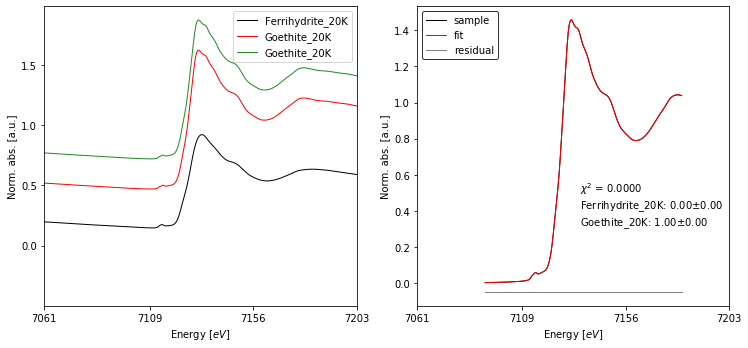

In [19]:
import os
import matplotlib.pyplot as plt

from araucaria.io import read_hdf5
from araucaria import Collection
from araucaria.fit import lcf, lcf_report, residuals
from araucaria.plot import fig_xas_template

# Path to the data, and the references 
dbpath    = os.path.join('Database_example_Fe.h5')
datname = 'Goethite_20K' # sample to fit
ref1_name = 'Ferrihydrite_20K' # ref #1
ref2_name = 'Goethite_20K' # ref #2 (possible to add more ref or to fit with only one) 

# Parameters normalization, background removal
k_edge = 7112
pre_edge_kws = {'pre_range':[-160, -40], 'post_range': [140, 950], 'nvict':0, 'e0':7125} 
autobk_kws = {'rbkg' : 1, 'k_range' : [2.5, 14], 'kweight' : 2, 'win' : 'hanning'}

# Figure parameters
fig_kws  = {'figsize'   : (10.5, 5)}  # size figure
fig_pars = {'e_range'  : (k_edge-50, k_edge+90),
           'e_ticks'   : [k_edge-51, k_edge-3, k_edge+44, k_edge+91],
           'k_range'   : [-0.1,16.3],
           'k_weight'  : 2,
           'k_ticks'   : [0,2,4,6,8,10,12,14,16],
           'r_range'   : [0, 8],
           'r_ticks'   : [0,2,4,6,8],
           'prop_cycle': [{'color'     : ['black', 'red', 'forestgreen', 'saddlebrown', 'darkorange', 
                                          'mediumturquoise', 'darkslategrey', 'darkmagenta'],
                           'linewidth' : [1, 1, 1, 1, 1, 1, 1, 1],},
                          {'color'     : ['black', 'red', 'grey'],
                           'linewidth' : [1, 1, 1],}
                         ]}

# Data importation, creation of the collection 
data = read_hdf5(os.path.join(dbpath), name = datname)
ref1 = read_hdf5(os.path.join(dbpath), name = ref1_name)
ref2 = read_hdf5(os.path.join(dbpath), name = ref2_name)

collection = Collection()
tags = ['scan', 'ref', 'ref']

for i, group in enumerate ((data, ref1, ref2)):
    collection.add_group(group, tag=tags[i])

# Fitting (LCF)    
for i in range(20):
    out = lcf(collection, fit_region='xanes', fit_range = [k_edge-20,k_edge+70], sum_one=False,
              pre_edge_kws = pre_edge_kws, autobk_kws = autobk_kws) 
    # change xanes for exafs function of the region you want to fit / change the fit_range for exafs fitting

# Pritting results
print(lcf_report(out))

# Initializing plot axes
fig, ax = fig_xas_template(panels = 'xx', fig_pars = fig_pars, **fig_kws)

ax[0].plot(ref1.energy, ref1.mu, label = ref1_name)
ax[0].plot(data.energy, data.mu + 0.25, label = datname)
ax[0].plot(ref2.energy, ref2.mu + 0.50, label = ref2_name)
ax[0].legend()

ax[1].plot(out.energy, out.scan, label = 'sample')
ax[1].plot(out.energy, out.fit, label = 'fit')
ax[1].plot(out.energy, out.min_pars.residual - 0.05, label='residual')
ax[1].legend(loc='upper left', edgecolor='k', fontsize=10)

# Summary report
summary = r'$\chi^2$ = %1.4f' % out.min_pars.chisqr +'\n'
val1 = out.min_pars.params['amp1'].value
err1 = out.min_pars.params['amp1'].stderr
summary += out.refgroups[0]+r': %1.2f$\pm$%1.2f' % (val1, err1)
summary += '\n'
val2 = out.min_pars.params['amp2'].value
err2 = out.min_pars.params['amp2'].stderr
summary += out.refgroups[1]+r': %1.2f$\pm$%1.2f' % (val2, err2)
summary += '\n'
ax[1].text(7135, 0.4, summary, ha='left', va='center', fontsize=10)

plt.show()